# Primer análisis básico para definir posibles bases de datos a utilizar

### Cargo paquetes

In [1]:
# Load packages
import sys
sys.path.insert(0, '/datos/julian.giles/Scripts/python')

import matplotlib

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs	
import cartopy.feature 	
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
from numpy import ma 
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.colors as mcolors
import os
from matplotlib import gridspec
import scipy.stats
from scipy import signal
import gc
import juli_functions
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from skimage.feature import peak_local_max
import itertools
import math
import timeit
from scipy import stats
import collections
import seaborn as sns

### Cargo datos

In [2]:
# ERA5-Land data
era5land_path = '/datosfreyja/d1/GDATA/ERA5-Land/'
era5land = xr.open_mfdataset(era5land_path+'*/*.nc')

In [3]:
era5land

<xarray.Dataset>
Dimensions:    (latitude: 11, longitude: 11, time: 26304)
Coordinates:
  * longitude  (longitude) float32 -63.0 -62.9 -62.8 -62.7 ... -62.2 -62.1 -62.0
  * latitude   (latitude) float32 -32.0 -32.1 -32.2 -32.3 ... -32.8 -32.9 -33.0
  * time       (time) datetime64[ns] 2019-01-01 ... 2021-12-31T23:00:00
Data variables:
    lai_hv     (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    lai_lv     (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    sp         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    swvl2      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    swvl3      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    swvl4      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-09 06:15:32 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [4]:
# Observations
obs_path = '/datos/julian.giles/flash_flood/justiniano_posse/'

justiniano_posse = pd.read_csv(obs_path+'ClimaReporte_omixom_JustinianoPosse.csv', sep=';', low_memory=False, skip_blank_lines=True, parse_dates=['Fecha'], infer_datetime_format=True).dropna(how='all')

dique_aforador = pd.read_csv(obs_path+'Altura_diqueAforador_Estacion-4216.csv', sep=';', low_memory=False, skip_blank_lines=True, header=1, parse_dates=['Fecha y Hora'], infer_datetime_format=True).dropna(how='all')

landsat = pd.read_csv(obs_path+'data_Cappellettietal.csv', sep=',', low_memory=False, skip_blank_lines=True, parse_dates=['Fecha'], infer_datetime_format=True).dropna(how='all')

In [5]:
justiniano_posse

,Fecha,Temperatura [°C],Humedad [%HR],Punto de rocío [°C],Registro de Lluvia [mm],Velocidad de Viento [Km/h],Direccion de Viento [°],Dirección de Viento-(Rosa de los Vientos) [],Rafaga de Viento [km/h],Presion [hPa],Radiacion Solar [w/m2],Temperatura de suelo [°C],Nivel de Napa Freática [cm]
0,2018-08-14 11:20:00,18.1,32.0,NaN,0.0,5.9,67.5,ENE,7.7,978.8,13.0,17.2,17.0
1,2018-08-14 11:30:00,18.1,31.7,NaN,0.0,6.0,67.5,ENE,7.4,978.8,13.0,17.2,17.0
2,2018-08-14 11:40:00,18.1,31.8,NaN,0.0,6.0,67.5,ENE,7.9,977.5,13.0,17.2,17.0
3,2018-08-14 11:50:00,18.1,32.0,NaN,0.0,6.1,67.5,ENE,8.4,977.5,13.0,17.2,17.0
4,2018-08-14 12:00:00,18.1,32.0,NaN,0.0,6.1,67.5,ENE,8.1,977.5,12.0,17.3,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139458,2022-02-08 10:30:00,23.1,64.8,16.1,0.0,9.8,67.5,ENE,20.3,1003.8,677.4,19.6,-261.2
139459,2022-02-08 10:40:00,23.3,64.4,16.2,0.0,10.5,67.5,ENE,20.7,1003.8,705.1,19.7,-261.2
139460,2022-02-08 10:50:00,23.6,65.5,16.8,0.0,9.5,112.5,ESE,21.3,1002.5,728.8,19.7,-261.2
139461,2022-02-08 11:00:00,23.9,64.5,16.8,0.0,10.5,112.5,ESE,23.0,1001.9,752.5,19.8,-261.2


<AxesSubplot:xlabel='Fecha'>

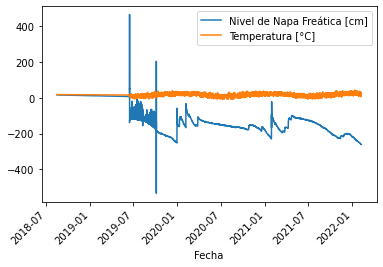

In [6]:
justiniano_posse.plot(x='Fecha', y=['Nivel de Napa Freática [cm]', 'Temperatura [°C]'], rot=45)

In [7]:
dique_aforador

,Fecha y Hora,Altura [m]
0,2019-12-19 13:00:00,0.00
1,2019-12-19 14:00:00,0.00
2,2019-12-19 15:00:00,0.00
3,2019-12-19 16:00:00,0.00
4,2019-12-19 17:00:00,0.00
...,...,...
14778,2022-02-08 15:00:00,1.34
14779,2022-02-08 16:00:00,1.34
14780,2022-02-08 17:00:00,1.33
14781,2022-02-08 18:00:00,1.33


<AxesSubplot:xlabel='Fecha y Hora'>

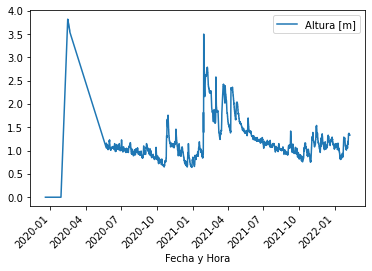

In [8]:
dique_aforador.plot(x='Fecha y Hora', rot=45)


In [9]:
landsat

,Fecha,Lluvia Acumulada [mm],Rolling_5_Sum,nivel napa promedio [cm],flood_surface,mixwater_surface
0,2019-09-01,0.0,0.0,-139.9,5400.0,5172.0
1,2019-09-02,0.0,0.0,-141.3,NaN,NaN
2,2019-09-03,0.0,0.0,-144.5,NaN,NaN
3,2019-09-04,0.0,0.0,-145.5,NaN,NaN
4,2019-09-05,0.0,0.0,-144.3,NaN,NaN
...,...,...,...,...,...,...
605,2021-04-28,0.2,0.2,-104.0,NaN,NaN
606,2021-04-29,0.0,0.2,-104.7,NaN,NaN
607,2021-04-30,0.0,0.2,-104.8,NaN,NaN
608,2021-05-01,0.0,0.2,-105.3,4071.0,3616.0


<AxesSubplot:xlabel='Fecha'>

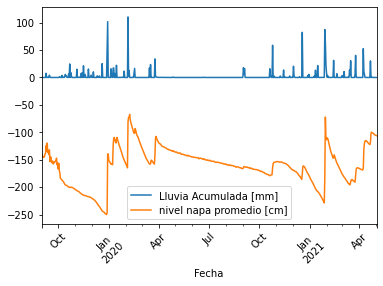

In [10]:
landsat.plot(x='Fecha', y=['Lluvia Acumulada [mm]', 'nivel napa promedio [cm]'], rot=45)


#### Busco arrancar desde donde los datos parecen más decentes, veamos junio 2020

<AxesSubplot:xlabel='Fecha'>

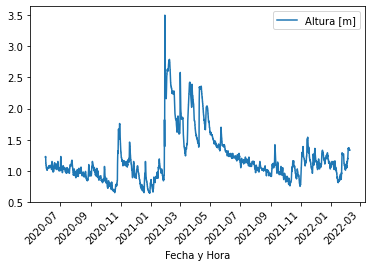

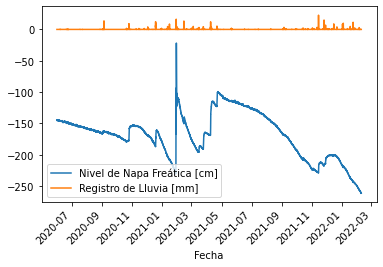

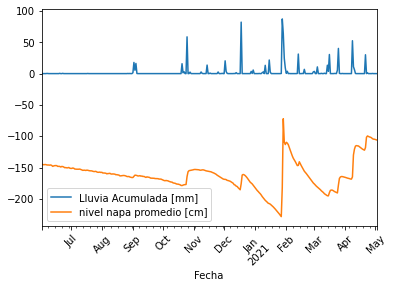

In [11]:
fromdate = '2020-06-01 00:00:00'
#todate = '2021-12-31 00:00:00'

dique_aforador_short = dique_aforador.loc[dique_aforador['Fecha y Hora']>fromdate].reset_index(drop=True)
justiniano_posse_short = justiniano_posse.loc[justiniano_posse['Fecha']>fromdate].reset_index(drop=True)
landsat_short = landsat.loc[landsat['Fecha']>fromdate].reset_index(drop=True)

dique_aforador_short.plot(x='Fecha y Hora', y='Altura [m]', rot=45)
justiniano_posse_short.plot(x='Fecha', y=['Nivel de Napa Freática [cm]', 'Registro de Lluvia [mm]'], rot=45)
landsat_short.plot(x='Fecha', y=['Lluvia Acumulada [mm]', 'nivel napa promedio [cm]'], rot=45)


#### Comparemos algunas variables entre datasets

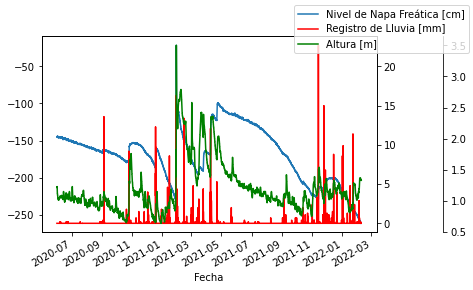

In [12]:
# datos de estaciones
ax = justiniano_posse_short.plot(x="Fecha", y="Nivel de Napa Freática [cm]", legend=False)
ax2 = ax.twinx()
justiniano_posse_short.plot(x="Fecha", y="Registro de Lluvia [mm]", ax=ax2, legend=False, color="r")
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
dique_aforador_short.plot(x="Fecha y Hora", y="Altura [m]", ax=ax3, legend=False, color="g")


ax.figure.legend()
plt.show()

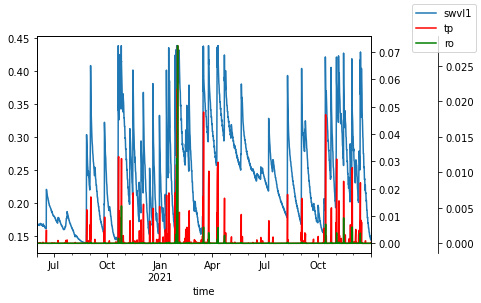

In [13]:
# datos de ERA5
era5land_loc = era5land.loc[{'latitude':-32.9, 'longitude': -62.6, 'time': slice('2020-06-01', '2021-12-31')}].to_dataframe().reset_index()
era5land_loc['time'] = pd.to_datetime(era5land_loc['time'], infer_datetime_format=True)

ax = era5land_loc.plot(x='time', y='swvl1', legend=False)
ax2 = ax.twinx()
era5land_loc.plot(x='time', y='tp', ax=ax2, legend=False, color="r")
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
era5land_loc.plot(x='time', y='ro', ax=ax3, legend=False, color="g")


ax.figure.legend()
plt.show()

<IPython.core.display.Javascript object>


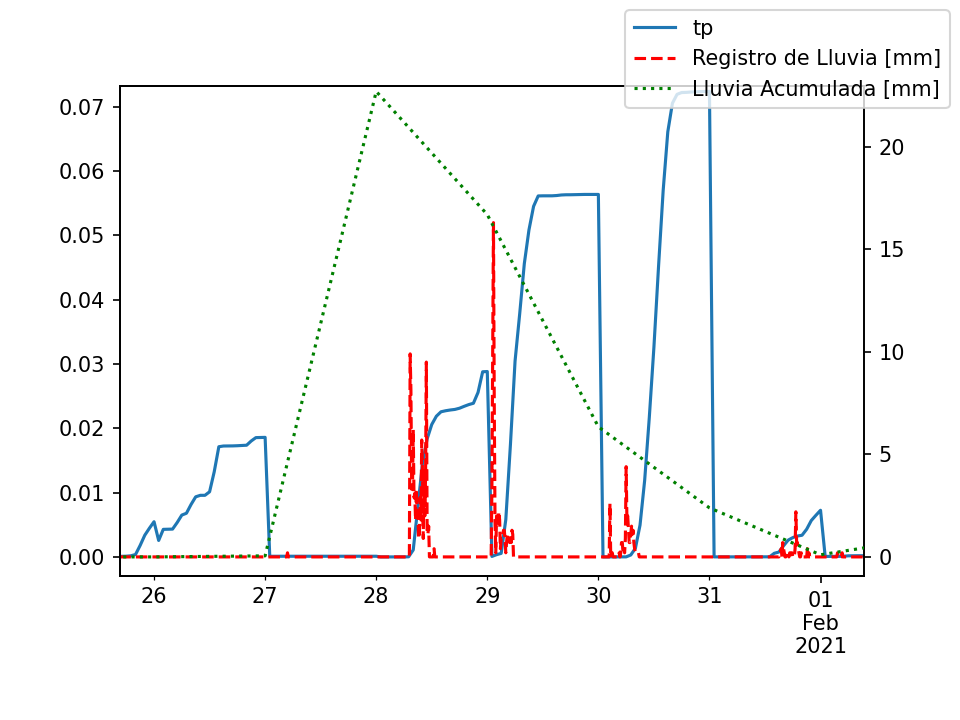

In [75]:
# Comparacion lluvia 
%matplotlib notebook

fig, ax = plt.subplots()
ax.plot(era5land_loc['time'], era5land_loc['tp'], label='tp')
ax2 = ax.twinx()
justiniano_posse_short.set_index('Fecha').plot(y="Registro de Lluvia [mm]", ax=ax2, legend=False, color="r", ls = 'dashed')
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
landsat_short.set_index('Fecha').plot(y="Lluvia Acumulada [mm]", ax=ax3, legend=False, color="g", ls='dotted')

ax.figure.legend()
plt.show()

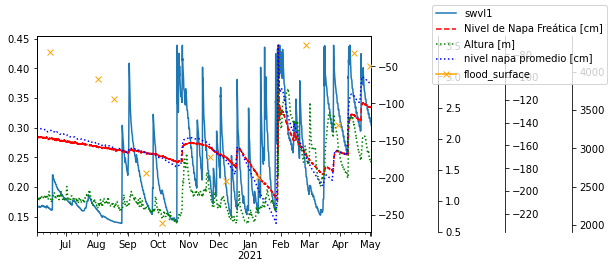

In [60]:
# Comparación de SM de ERA5, Altura de napa de JP, Altura de Río de Dique Aforador y superficie inundada de LandSat
fig, ax = plt.subplots()
ax.plot(era5land_loc['time'], era5land_loc['swvl1'], label='swvl1')
ax2 = ax.twinx()
justiniano_posse_short.set_index('Fecha').plot(y="Nivel de Napa Freática [cm]", ax=ax2, legend=False, color="r", ls = 'dashed')
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
dique_aforador_short.set_index('Fecha y Hora').plot(y="Altura [m]", ax=ax3, legend=False, color="g", ls='dotted')
ax4 = ax.twinx()
ax4.spines["right"].set_position(("axes", 1.4))
landsat_short.set_index('Fecha').plot(y="nivel napa promedio [cm]", ax=ax4, legend=False, color="b", ls='dotted')
ax5 = ax.twinx()
ax5.spines["right"].set_position(("axes", 1.6))
landsat_short.set_index('Fecha').plot(y="flood_surface", ax=ax5, legend=False, color="orange", marker='x')

ax.figure.legend()
plt.show()

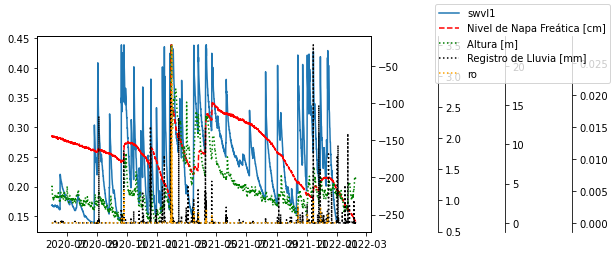

In [70]:
# Comparación de SM de ERA5, Altura de napa de JP, Altura de Río de Dique Aforador y runoff ERA5
fig, ax = plt.subplots()
ax.plot(era5land_loc['time'], era5land_loc['swvl1'], label='swvl1')
ax2 = ax.twinx()
justiniano_posse_short.set_index('Fecha').plot(y="Nivel de Napa Freática [cm]", ax=ax2, legend=False, color="r", ls = 'dashed')
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
dique_aforador_short.set_index('Fecha y Hora').plot(y="Altura [m]", ax=ax3, legend=False, color="g", ls='dotted')
ax5 = ax.twinx()
ax5.spines["right"].set_position(("axes", 1.4))
justiniano_posse_short.set_index('Fecha').plot(y="Registro de Lluvia [mm]", ax=ax5, legend=False, color="black", ls='dotted')
ax4 = ax.twinx()
ax4.spines["right"].set_position(("axes", 1.6))
ax4.plot(era5land_loc['time'], era5land_loc['ro'], label='ro', color='orange', ls='dotted')

ax.figure.legend()
plt.show()

<IPython.core.display.Javascript object>


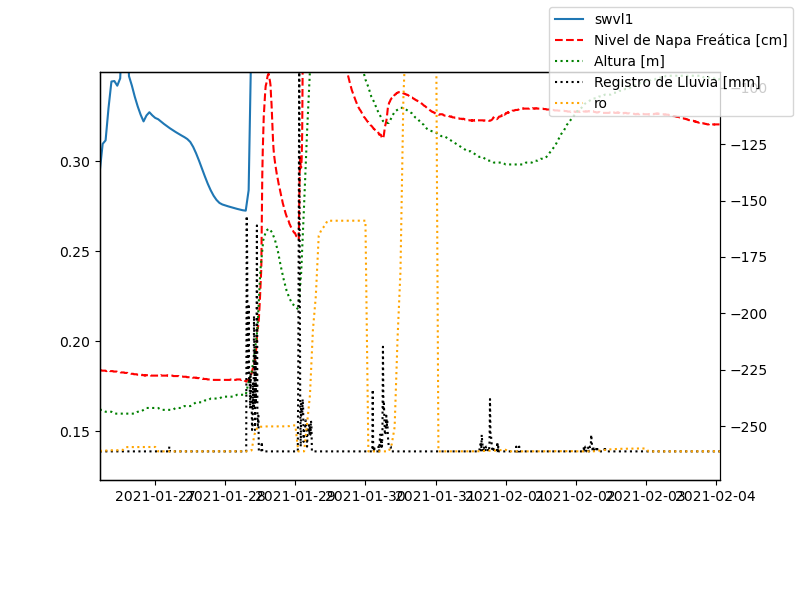

In [74]:
# Comparación de SM de ERA5, Altura de napa de JP, Altura de Río de Dique Aforador y runoff ERA5
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(era5land_loc['time'], era5land_loc['swvl1'], label='swvl1')
ax2 = ax.twinx()
justiniano_posse_short.set_index('Fecha').plot(y="Nivel de Napa Freática [cm]", ax=ax2, legend=False, color="r", ls = 'dashed')
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
dique_aforador_short.set_index('Fecha y Hora').plot(y="Altura [m]", ax=ax3, legend=False, color="g", ls='dotted')
ax5 = ax.twinx()
ax5.spines["right"].set_position(("axes", 1.4))
justiniano_posse_short.set_index('Fecha').plot(y="Registro de Lluvia [mm]", ax=ax5, legend=False, color="black", ls='dotted')
ax4 = ax.twinx()
ax4.spines["right"].set_position(("axes", 1.6))
ax4.plot(era5land_loc['time'], era5land_loc['ro'], label='ro', color='orange', ls='dotted')

ax.figure.legend()
plt.show()

#### En teoría los datos de LandSat son los mismos que los de Justiniano Posse, pero no estamos seguros, mejor usar los de JP.

<AxesSubplot:xlabel='Fecha'>

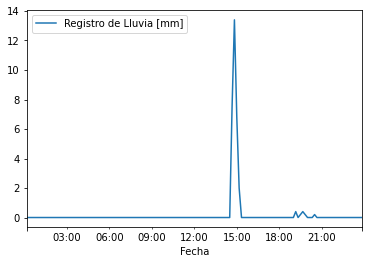

In [39]:
justiniano_posse_short.loc[justiniano_posse_short['Fecha']>'2021-02-13'].loc[justiniano_posse_short['Fecha']<'2021-02-14'].plot(x= 'Fecha', y='Registro de Lluvia [mm]')

<AxesSubplot:xlabel='Fecha'>

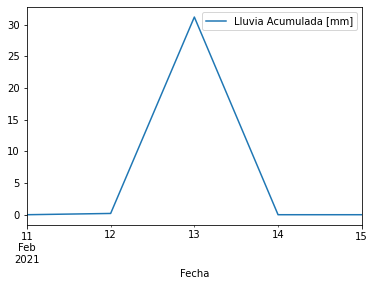

In [37]:
landsat_short.loc[landsat_short['Fecha']>'2021-02-10'].loc[landsat_short['Fecha']<'2021-02-16'].plot(x='Fecha',y='Lluvia Acumulada [mm]')

In [43]:
landsat_short

,Fecha,Lluvia Acumulada [mm],Rolling_5_Sum,nivel napa promedio [cm],flood_surface,mixwater_surface
0,2020-06-02,0.0,0.0,-144.5,NaN,NaN
1,2020-06-03,0.0,0.0,-145.3,NaN,NaN
2,2020-06-04,0.0,0.0,-145.5,NaN,NaN
3,2020-06-05,0.0,0.0,-145.3,NaN,NaN
4,2020-06-06,0.0,0.0,-145.3,NaN,NaN
...,...,...,...,...,...,...
330,2021-04-28,0.2,0.2,-104.0,NaN,NaN
331,2021-04-29,0.0,0.2,-104.7,NaN,NaN
332,2021-04-30,0.0,0.2,-104.8,NaN,NaN
333,2021-05-01,0.0,0.2,-105.3,4071.0,3616.0


<AxesSubplot:xlabel='time'>

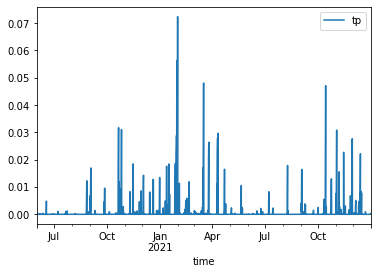

In [20]:
era5land_loc.plot(x="time", y="tp")

<AxesSubplot:xlabel='Fecha'>

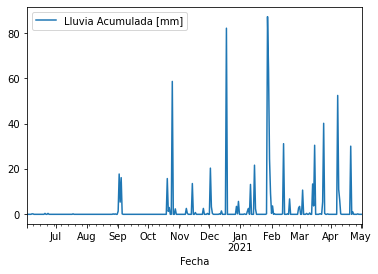

In [22]:
landsat_short.plot(x="Fecha", y="Lluvia Acumulada [mm]")

In [106]:
era5land_loc['time']

0       2020-06-01 00:00:00
1       2020-06-01 01:00:00
2       2020-06-01 02:00:00
3       2020-06-01 03:00:00
4       2020-06-01 04:00:00
                ...        
13891   2021-12-31 19:00:00
13892   2021-12-31 20:00:00
13893   2021-12-31 21:00:00
13894   2021-12-31 22:00:00
13895   2021-12-31 23:00:00
Name: time, Length: 13896, dtype: datetime64[ns]

In [107]:
justiniano_posse_short['Fecha']

0       2020-06-01 00:10:00
1       2020-06-01 00:20:00
2       2020-06-01 00:30:00
3       2020-06-01 00:40:00
4       2020-06-01 00:50:00
                ...        
88582   2022-02-08 10:30:00
88583   2022-02-08 10:40:00
88584   2022-02-08 10:50:00
88585   2022-02-08 11:00:00
88586   2022-02-08 11:10:00
Name: Fecha, Length: 88587, dtype: datetime64[ns]

In [108]:
landsat_short['Fecha']

0     2020-06-02
1     2020-06-03
2     2020-06-04
3     2020-06-05
4     2020-06-06
         ...    
330   2021-04-28
331   2021-04-29
332   2021-04-30
333   2021-05-01
334   2021-05-02
Name: Fecha, Length: 335, dtype: datetime64[ns]

In [115]:
############
# Observations
obs_path = '/datos/julian.giles/flash_flood/justiniano_posse/'

justiniano_posse = pd.read_csv(obs_path+'ClimaReporte_omixom_JustinianoPosse.csv', sep=';', low_memory=False, skip_blank_lines=True).dropna(how='all')

dique_aforador = pd.read_csv(obs_path+'Altura_diqueAforador_Estacion-4216.csv', sep=';', low_memory=False, skip_blank_lines=True, header=1).dropna(how='all')

landsat = pd.read_csv(obs_path+'data_Cappellettietal.csv', sep=',', low_memory=False, skip_blank_lines=True).dropna(how='all')

In [129]:
justiniano_posse['Fecha'] = pd.to_datetime(justiniano_posse['Fecha'], infer_datetime_format=True)
landsat['Fecha'] = pd.to_datetime(landsat['Fecha'], infer_datetime_format=True)

<AxesSubplot:xlabel='Fecha'>

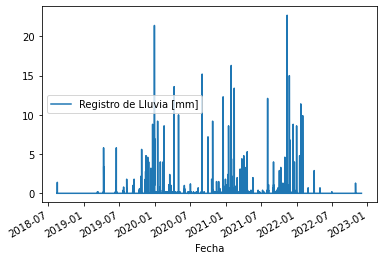

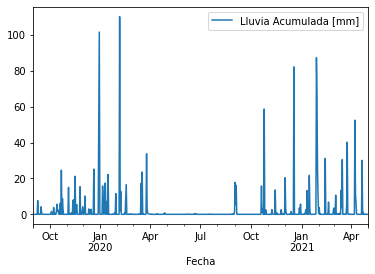

In [130]:
justiniano_posse.plot(x='Fecha', y ='Registro de Lluvia [mm]')
landsat.plot(x='Fecha', y='Lluvia Acumulada [mm]')

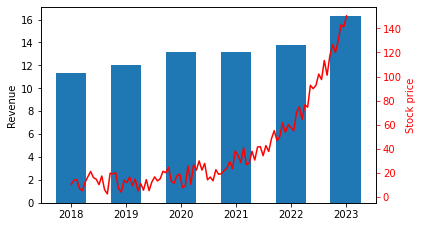

In [166]:
# Made up Stock price data
stock_price = np.random.random_sample(size=100)*20+np.exp(0.05*np.arange(100))
stock_price_df = pd.DataFrame({'dates':pd.date_range(start='1/1/2018', end='1/08/2023',periods=len(stock_price)), 'stock price':stock_price})
stock_price_df = stock_price_df.set_index('dates')

# Made up revenue data
revenue = np.random.random_sample(size=100)*20+np.exp(0.02*np.arange(100))
revenue_df= pd.DataFrame({'dates':pd.date_range(start='1/1/2018', end='1/08/2023',periods=len(revenue)), 'revenue': revenue})
revenue_df = revenue_df.set_index('dates')
revenue_df_agg = revenue_df.resample('Y').mean().reset_index()

# Plot two of them together
fig, ax = plt.subplots()
ax.bar(pd.to_datetime(revenue_df_agg['dates'].dt.year, format='%Y'), revenue_df_agg['revenue'], width=200)
ax.set_ylabel('Revenue')
ax1 = ax.twinx()
s = stock_price_df['stock price'].plot(ax = ax1, style = '-r')
ax1.set_ylabel('Stock price')
ax1.yaxis.label.set_color('r')
ax1.yaxis.label.set_color('r')
ax1.tick_params(axis='y', colors='r')
plt.savefig('collage-2.png')
plt.show()

In [132]:
stock_price_df

,stock price
dates,
2018-01-01 00:00:00.000000000,15.428797
2018-01-19 12:21:49.090909091,8.518496
2018-02-07 00:43:38.181818182,17.337158
2018-02-25 13:05:27.272727273,16.924797
2018-03-16 01:27:16.363636364,5.681720
...,...
2022-10-25 22:32:43.636363648,130.331592
2022-11-13 10:54:32.727272736,123.782451
2022-12-01 23:16:21.818181824,145.288293


In [152]:
revenue_df_agg

,dates,revenue
0,2018-12-31,11.085450
1,2019-12-31,10.581187
2,2020-12-31,13.298996
3,2021-12-31,12.316969
4,2022-12-31,17.773102
5,2023-12-31,15.047858


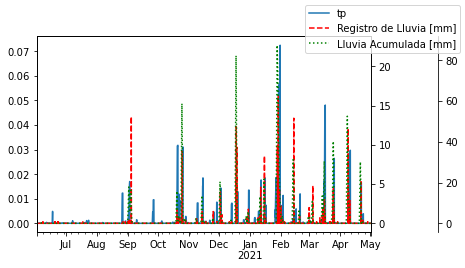

In [173]:
# Comparacion lluvia 
fig, ax = plt.subplots()
ax.plot(era5land_loc['time'], era5land_loc['tp'], label='tp')
ax2 = ax.twinx()
justiniano_posse_short.set_index('Fecha').plot(y="Registro de Lluvia [mm]", ax=ax2, legend=False, color="r", ls = 'dashed')
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
landsat_short.set_index('Fecha').plot(y="Lluvia Acumulada [mm]", ax=ax3, legend=False, color="g", ls='dotted')

ax.figure.legend()
plt.show()

In [174]:
landsat_short

,Fecha,Lluvia Acumulada [mm],Rolling_5_Sum,nivel napa promedio [cm],flood_surface,mixwater_surface
0,2020-06-02,0.0,0.0,-144.5,NaN,NaN
1,2020-06-03,0.0,0.0,-145.3,NaN,NaN
2,2020-06-04,0.0,0.0,-145.5,NaN,NaN
3,2020-06-05,0.0,0.0,-145.3,NaN,NaN
4,2020-06-06,0.0,0.0,-145.3,NaN,NaN
...,...,...,...,...,...,...
330,2021-04-28,0.2,0.2,-104.0,NaN,NaN
331,2021-04-29,0.0,0.2,-104.7,NaN,NaN
332,2021-04-30,0.0,0.2,-104.8,NaN,NaN
333,2021-05-01,0.0,0.2,-105.3,4071.0,3616.0


In [162]:
justiniano_posse_short['Fecha']

0       2020-06-01 00:10:00
1       2020-06-01 00:20:00
2       2020-06-01 00:30:00
3       2020-06-01 00:40:00
4       2020-06-01 00:50:00
                ...        
88582   2022-02-08 10:30:00
88583   2022-02-08 10:40:00
88584   2022-02-08 10:50:00
88585   2022-02-08 11:00:00
88586   2022-02-08 11:10:00
Name: Fecha, Length: 88587, dtype: datetime64[ns]

In [ ]:
dique_aforador_xr = xr.Dataset.from_dataframe(dique_aforador)

In [49]:
dique_aforador_xr

<xarray.Dataset>
Dimensions:       (index: 14783)
Coordinates:
  * index         (index) int64 0 1 2 3 4 5 ... 14778 14779 14780 14781 14782
Data variables:
    Fecha y Hora  (index) object '19/12/2019 13:00' ... '08/02/2022 19:00'
    Altura [m]    (index) float64 0.0 0.0 0.0 0.0 0.0 ... 1.34 1.33 1.33 1.33